In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.constraints import *
from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.table.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Meshcat url:  http://127.0.0.1:7000/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Set up grammar and constraint set.
pyro.set_rng_seed(44)
grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
    sample_params_from_prior=True
)
constraints = [
    ObjectsOnTableConstraint(),
    ObjectSpacingConstraint()
]
# While I'm OK with most parameters being randomly sampled, a few of
# them break convergence. Those, I'll manually set translation params
# to zero-mean and reasonable variance. (Bingham dist rotation params
# are set to low-concentration by default.)
for rule_params in grammar.rule_params_by_node_type["SteamerBottom"][:2]:
    # Translation
    rule_params[0]["mean"].set(torch.zeros(3))
    rule_params[0]["variance"].set(torch.ones(3)*0.05)
for rule_params in grammar.rule_params_by_node_type["PersonalPlateAndTeacup"]:
    # Translation
    rule_params[0]["mean"].set(torch.zeros(3))
    rule_params[0]["variance"].set(torch.ones(3)*0.05)
for rule_params in grammar.rule_params_by_node_type["PlaceSetting"][1:3]:
    # Translation
    rule_params[0]["mean"].set(torch.zeros(3))
    rule_params[0]["variance"].set(torch.ones(3)*0.05)

In [4]:
# Load dataset and draw an example from it
target_dataset_trees = []
with open("target_dataset_examples.pickle", "rb") as f:
    while 1:
        try:
            target_dataset_trees.append(pickle.load(f))
        except EOFError:
            break
print("Loaded %d environments" % len(target_dataset_trees))
observed_node_sets = [tree.get_observed_nodes() for tree in target_dataset_trees]
# NOTE: GT trees aren't perfect, as they're post-sim; their scores may be
# totally invalid.

ex_k = 12
draw_scene_tree_contents_meshcat(target_dataset_trees[ex_k], zmq_url=vis.window.zmq_url,  prefix="test_tree/contents")
draw_scene_tree_structure_meshcat(target_dataset_trees[ex_k], zmq_url=vis.window.zmq_url,  prefix="test_tree/structure",
                                  with_triad=False, linewidth=30, node_sphere_size=0.02)

[2022-02-16 18:02:57.029] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Loaded 100 environments


In [5]:
n_objs_per_env = np.array([len([n for n in nodes if isinstance(n, SteamerBottom)]) for nodes in observed_node_sets])
ranking = np.argsort(n_objs_per_env, axis=0).astype(np.int)
print(ranking[-10:], n_objs_per_env[ranking[-10:]])

[34 83 17  9 28 84 77 90 24 98] [4 4 4 5 5 6 6 6 6 6]


In [173]:
# Get environment and supertree stats
supertree = grammar.make_super_tree()
print("Supertree has %d nodes" % len(supertree.nodes))
n_objects = [len(nodes) for nodes in observed_node_sets]
print(np.mean(n_objects), np.std(n_objects), np.min(n_objects), np.max(n_objects))

Supertree has 186 nodes
11.92 2.5910615585122634 7 19


In [7]:
# Do EM fitting process
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=1, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (SharedTeapots): ConstrainedParameter()
    (Null): None
    (SharedDishes): ConstrainedParameter()
    (PersonalPlate): None
    (ServingDish): None
    (PlaceSettings): None
    (SteamerTop): None
    (Teapot): None
    (PlaceSetting): ConstrainedParameter()
    (Table): None
    (PersonalPlateAndTeacup): None
    (SharedStuff): ConstrainedParameter()
    (Teacup): None
    (SharedSteamers): ConstrainedParameter()
    (SteamerBottom): ConstrainedParameter()
  )
  (rule_params_by_node_type): ModuleDict(
    (SharedTeapots): ModuleList(
      (0): ModuleList(
        (0): ModuleDict(
          (mean): ConstrainedParameter()
          (variance): ConstrainedParameter()
        )
        (1): ModuleDict(
          (M): ConstrainedParameter()
          (Z): ConstrainedParameter()
        )
      )
    )
    (Null): ModuleList()
    (SharedDishes): ModuleList(
      (0): ModuleList(
        (0): ModuleDict(
          (mean): Con

In [13]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")
with open("fit_em.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Plotting and inspection of EM fitting process

In [6]:
fit_grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
)
fit_grammar.load_state_dict(torch.load("fit_grammar.torch"))

gt_grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
)
gt_grammar.load_state_dict(torch.load("target_dataset_grammar_state_dict.torch"))

with open("fit_em.pickle", "rb") as fp:
    em = pickle.load(fp)
    
# Load baseline as well
from spatial_scene_grammars_examples.table.grammar_baseline import *
grammar_baseline = SpatialSceneGrammar(
    root_node_type = TableBaseline,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
)
fit_grammar_baseline = SpatialSceneGrammar(
    root_node_type = TableBaseline,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
)
fit_grammar_baseline.load_state_dict(torch.load("fit_grammar_baseline.torch"))
with open("fit_em_baseline.pickle", "rb") as fp:
    em_baseline = pickle.load(fp)

In [6]:
# Parse that earlier example
# Try to parse "tree" sampled above
# Parse it with IP.
vis["ip_parses"].delete()
supertree = fit_grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

observed_nodes = observed_node_sets[ex_k]
proposed_poses_by_type = generate_candidate_node_pose_sets(
    fit_grammar, observed_nodes, max_recursion_depth=10, verbose=True
)
parse_trees = infer_mle_tree_with_mip_from_proposals(
    fit_grammar, observed_nodes, {}, verbose=2, N_solutions=4
)
for k, parse_tree in enumerate(parse_trees):
    score = parse_tree.score()
    print("SOL #%d: SCORE %f" % (k, score))
    draw_scene_tree_structure_meshcat(parse_tree, zmq_url=vis.window.zmq_url, prefix="ip_parses/%d_%f" % (k, score),
                                      with_triad=False, linewidth=30, node_sphere_size=0.02, alpha=0.5, color_by_score=[-20, 20])

Supertree size  126
18 top-down candidates.
26 bottom-up candidates.
Post final pruning:  44
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Feb  2 14:47:05 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 918 rows, 461 columns and 2286 nonzeros
Model fingerprint: 0x69343de8
Variable types: 0 continuous, 461 integer (461 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 902 rows and 416 columns
Presolve time: 0.00s
Presolved: 16 rows, 45 columns, 100 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective -1.524923e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -152.4923366 -152.4923

Node <spatial_scene_grammars_examples.table.grammar.PlaceSetting object at 0x7fb49412e128> getting tf tensor([[ 6.1232e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0000e+00,  6.1232e-17,  0.0000e+00,  5.0000e-01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  8.2500e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
Added PlaceSettings_95--(2)>PlaceSetting_126
Node <spatial_scene_grammars_examples.table.grammar.PlaceSetting object at 0x7fb465651f60> getting tf tensor([[ 6.1232e-17, -1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  6.1232e-17,  0.0000e+00, -5.0000e-01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  8.2500e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
Added PlaceSettings_95--(3)>PlaceSetting_127
Node <spatial_scene_grammars_examples.table.grammar.SharedTeapots object at 0x7fb46565f128> getting tf tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.00

Node score:  tensor([0.])
Node score:  tensor([0.])
Node score:  tensor(0.)
Rule score:  tensor([17.0057])
Rule score:  tensor([11.9237])
Node score:  tensor(0.)
Rule score:  tensor([17.8100])
Rule score:  tensor([11.8478])
Node score:  tensor([0.])
Node score:  tensor([0.])
Node score:  tensor([0.])
Node score:  tensor(-0.7715)
Rule score:  tensor([19.2342])
Node score:  tensor([0.])
Node score:  tensor([0.])
Node score:  tensor([0.])
Node score:  tensor([0.])
Node score:  tensor([0.])


In [13]:
# Get scores for GT trees by parsing.
gt_tree_scores = []
gt_trees = []
for observed_nodes in tqdm(observed_node_sets):
    trees = infer_mle_tree_with_mip_from_proposals(
        gt_grammar, observed_nodes, {}, verbose=0, N_solutions=1, max_recursion_depth=10
    )
    gt_trees.append(trees[0])
    gt_tree_scores.append(trees[0].score())

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
k = 0
print("GT SOL #%d: SCORE %f" % (k, gt_tree_scores[0]))
draw_scene_tree_contents_meshcat(gt_trees[k], zmq_url=vis.window.zmq_url, prefix="gt_parse/contents")
draw_scene_tree_structure_meshcat(gt_trees[k], zmq_url=vis.window.zmq_url, prefix="gt_parse/structure",
                                  with_triad=True, linewidth=30, node_sphere_size=0.02, alpha=0.5,
                                  color_by_score=[-20, 0])
# Get teacup scores relative to parent
for teacup_node in gt_trees[k].find_nodes_by_type(Teacup):
    parent = gt_trees[k].get_parent(teacup_node)
    print("Teacup pose: ", teacup_node.translation)
    print("Parent: ", parent, parent.translation)
    print("Rel pose in parent: ", torch.matmul(parent.rotation.T, (teacup_node.translation - parent.translation)))
    print("XYZ Score: ", parent.rules[teacup_node.rule_k].xyz_rule.score_child(parent, teacup_node))
    print("Rot Score: ", parent.rules[teacup_node.rule_k].rotation_rule.score_child(parent, teacup_node))

GT SOL #0: SCORE 19.687805
Node score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Node score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Node score:  tensor(-0.7215)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Rule score:  tensor(0.)
Node score:  tensor(-0.3054)
Rule score:  tensor(0.)
Node score:  tensor(-1.5581)
Rule score:  tensor(0.)
Node score:  tensor(-0.3054)
Rule score:  tensor(0.)
Node score:  tensor(-0.3054)
Rule score:  tensor(0.)
Node score:  tensor(-1.0986)
Rule score:  tensor([3.0574])
Rule score:  tensor([3.3863])
Node score:  tensor(-1.0986)
Rule score:  tensor([0.0985])
Rule score:  tensor([-0.7555])
Node score:  tensor(-0.4849)
Rule score:  tensor([0.2383])
Node score:  tensor(0.)
Rule score:  tensor([1.8063])
Rule score:  tensor([-0.6201])
Node score:  tensor([0.])
Node score:  tensor(0.)
Rule score:  tensor([5.3252])
Rule score:  tensor([5.8097])
Node score:  tensor(0.)
Rule score:

In [15]:
# Get final parsed trees
post_fit_trees = []
for observed_nodes in tqdm(observed_node_sets):
    trees = infer_mle_tree_with_mip_from_proposals(
        fit_grammar, observed_nodes, {}, verbose=0, N_solutions=10, max_recursion_depth=10
    )
    post_fit_trees.append(trees)

  0%|          | 0/100 [00:00<?, ?it/s]

(-3.3723719436327473, 3.3667334993527995, 0.0, 0.8194668437885715)

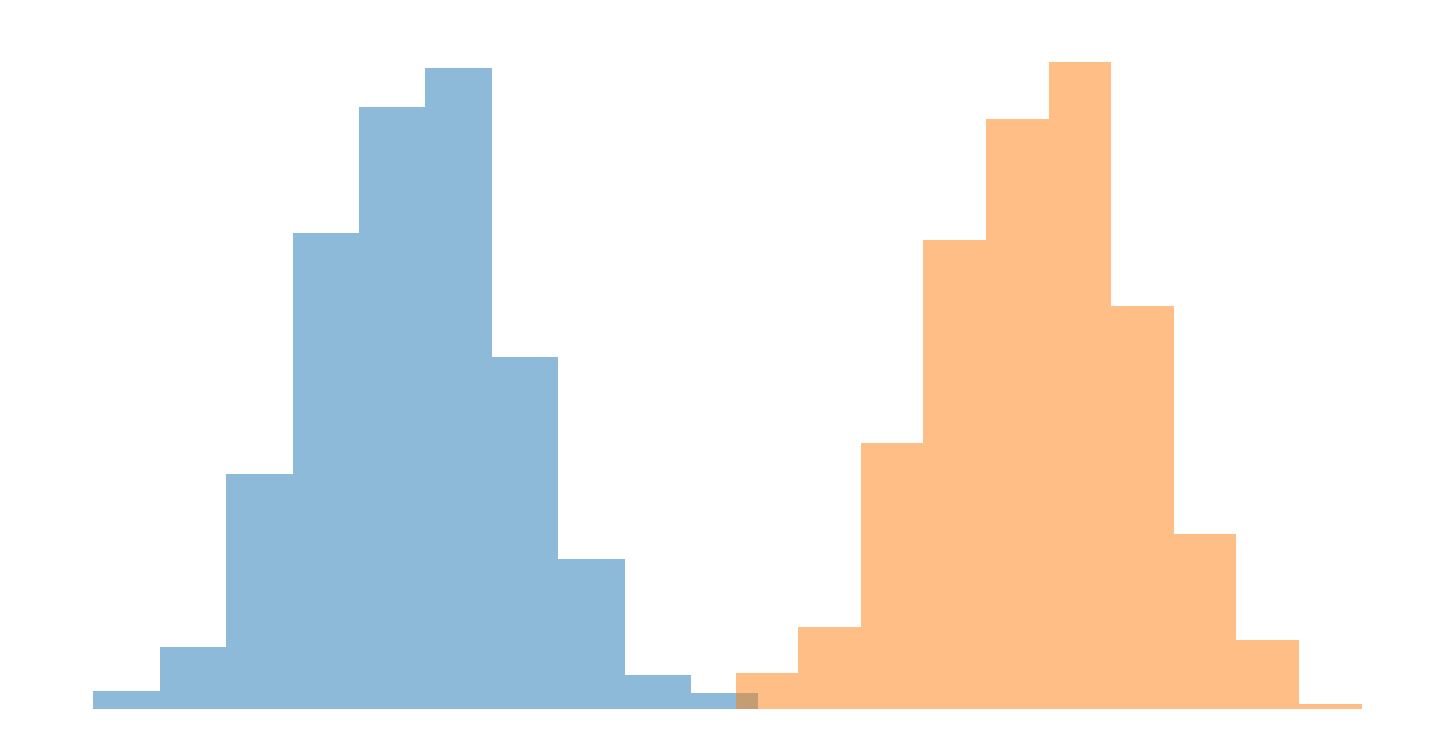

In [145]:
# Make a stupid normal plot for my talk
plt.figure(dpi=300).set_size_inches(6, 3)
plt.hist(np.random.normal(-1.5, 0.5, 1000), alpha=0.5, density=True)
plt.hist(np.random.normal(1.5, 0.5, 1000), alpha=0.5, density=True)
plt.axis(False)

Before:  -5510.527746884881 After:  14696.202159108701


Text(0.5, 1.0, 'Mean and std of scene log p(o)')

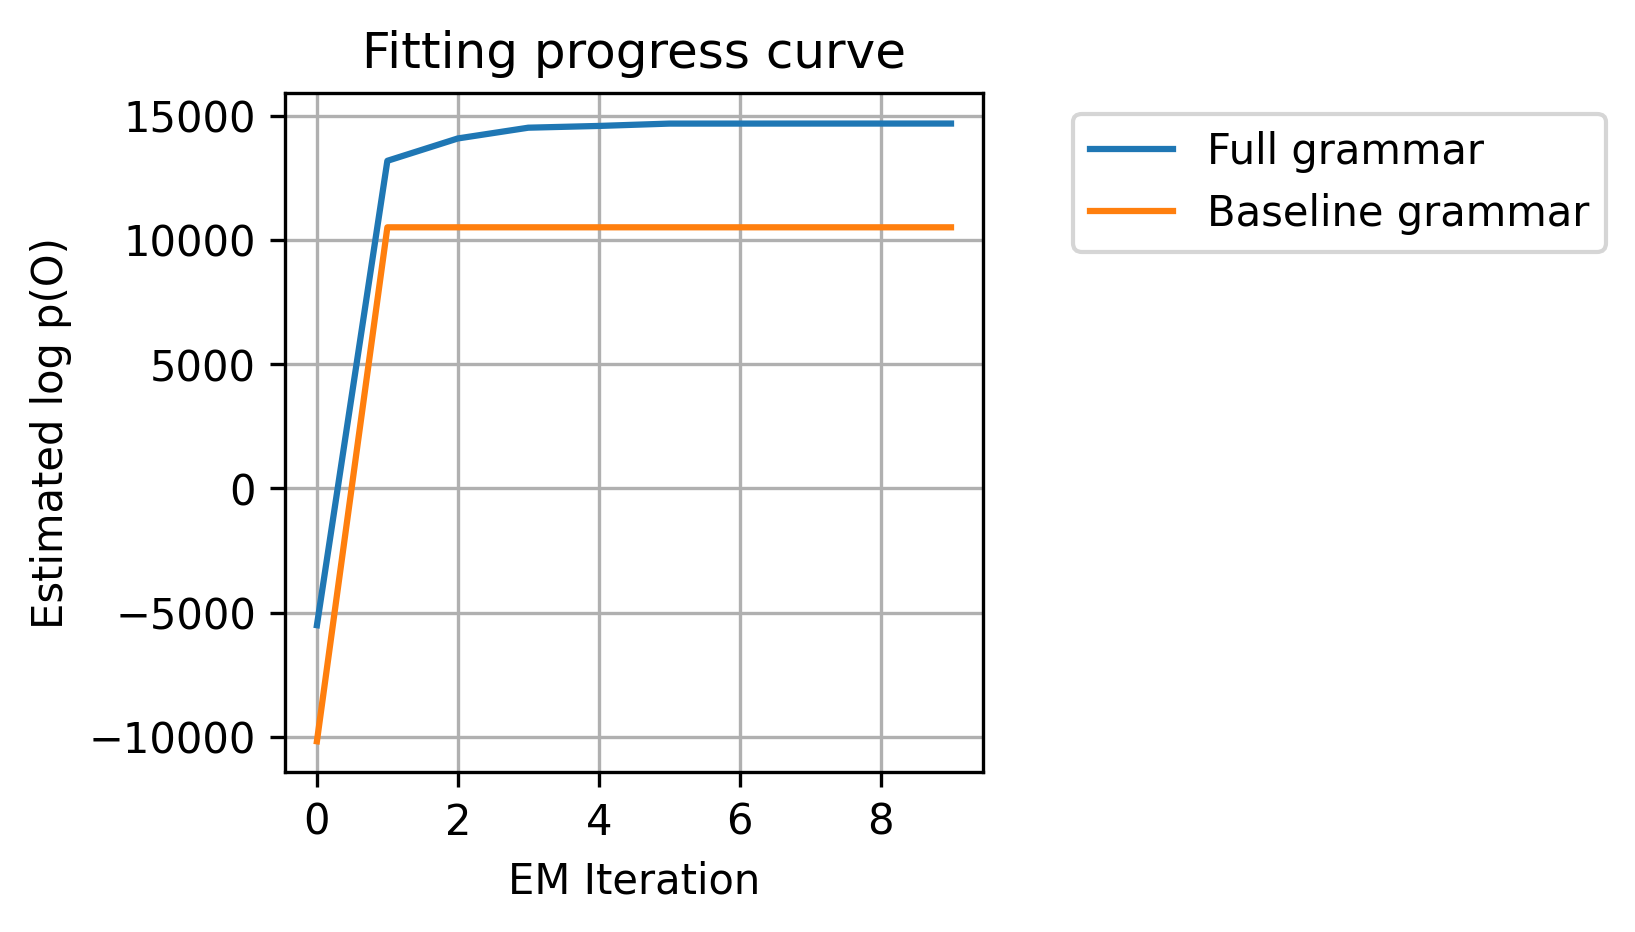

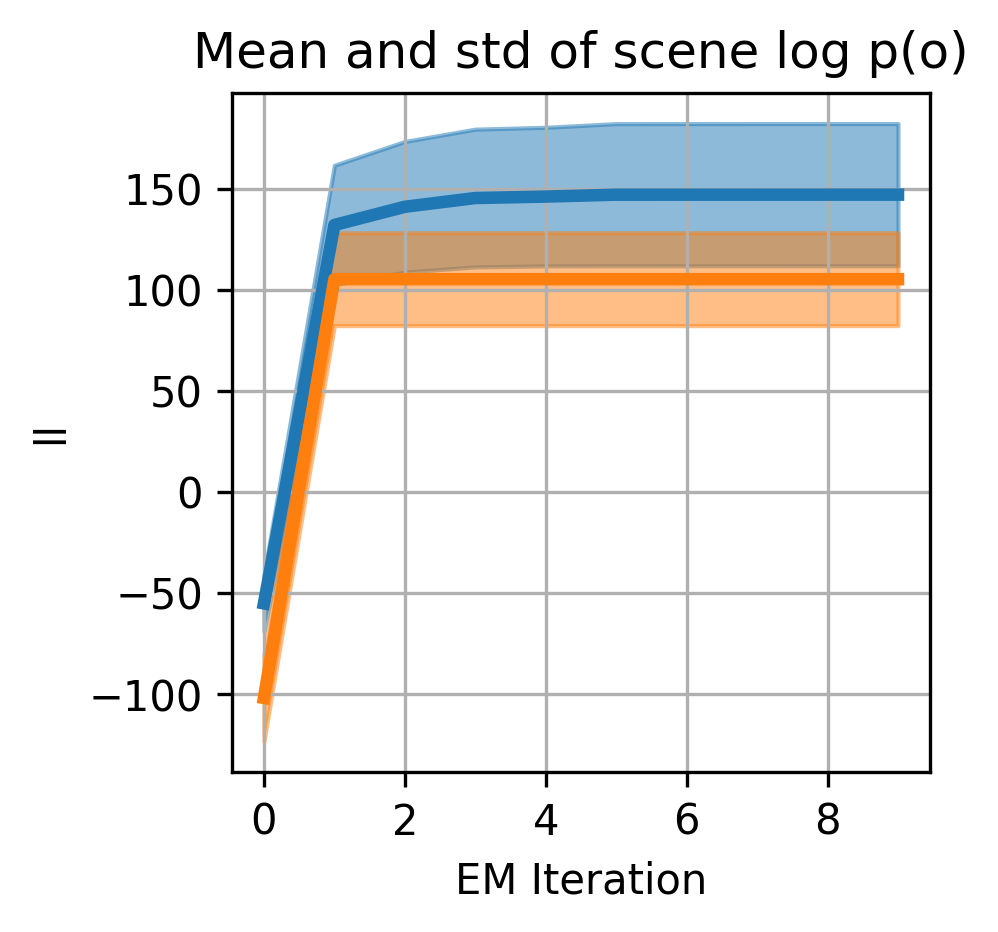

In [8]:
plt.figure(dpi=300).set_size_inches(3, 3)
totals = [np.sum(x) for x in em.log_evidence_iters]
totals_baseline = [np.sum(x) for x in em_baseline.log_evidence_iters]
plt.plot(totals, color="tab:blue", label="Full grammar")
plt.plot(totals_baseline, color="tab:orange", label="Baseline grammar")
plt.xlabel("EM Iteration")
plt.grid()
plt.ylabel("Estimated log p(O)")
#plt.axhline(np.sum(gt_tree_scores), linestyle="--", color="tab:green")
plt.title("Fitting progress curve")
print("Before: ", totals[0], "After: ", totals[-1])
plt.legend(bbox_to_anchor=[1.1, 1.])

# Slightly different: what's mean + avg p(o) for individual os look like?
plt.figure(dpi=300).set_size_inches(3, 3)
xs = range(len(em.log_evidence_iters))
means = np.array([np.mean(x) for x in em.log_evidence_iters])
stds = np.array([np.std(x) for x in em.log_evidence_iters])
plt.plot(xs, means, linewidth=3, color="tab:blue", label="Full grammar")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:blue")

means = np.array([np.mean(x) for x in em_baseline.log_evidence_iters])
stds = np.array([np.std(x) for x in em_baseline.log_evidence_iters])
plt.plot(xs, means, linewidth=3, color="tab:orange", label="Baseline grammar")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")


plt.xlabel("EM Iteration")
plt.grid()
plt.ylabel("ll")
plt.title("Mean and std of scene log p(o)")

In [65]:
# For each step over the fitting process, draw a population of samples from the
# candidate grammar, and collect the population of each terminal object type. Calculate
# MMDs against the corresponding populations of observed object types in the dataset.

# Precompute populations for dataset, and the dictionary we'll use to
# store the distance measurements.
observed_population_by_type = {}
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        key = type(observed_node).__name__
        if key not in observed_population_by_type.keys():
            observed_population_by_type[key] = []
        observed_population_by_type[key].append(observed_node.tf)
for key, value in observed_population_by_type.items():
    observed_population_by_type[key] = torch.stack(value)

mmds_by_type = {key: [] for key in observed_population_by_type.keys()}

# For each EM iteration...
N_samples = 1000
mmd_alphas = [0.01, 0.1, 1., 10., 100.]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sampled_population_by_type = {key: [] for key in observed_population_by_type.keys()}
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            key = type(observed_node).__name__
            if key not in sampled_population_by_type:
                logging.warning("Sampled object not in observations: %s" % key)
                sampled_population_by_type[key] = []
            sampled_population_by_type[key].append(observed_node.tf)
    for key, value in sampled_population_by_type.items():
        sampled_population_by_type[key] = torch.stack(value)
    # Compute MMDs
    for key in observed_population_by_type.keys():
        observed_pop = observed_population_by_type[key]
        sampled_pop = sampled_population_by_type[key]
        if observed_pop.shape[0] > 0 and sampled_pop.shape[0] > 0:
            mmds_by_type[key].append(
                calculate_mmd(observed_pop, sampled_pop, alphas=mmd_alphas, use_se3_metric=True, beta=0.1)
            )
        else:
            logging.warning("%d observed, %d sampled, can't compare." % (observed_pop.shape[0], sampled_pop.shape[0]))
            mmds_by_type[key].append(np.inf)
print(mmds_by_type)

  0%|          | 0/11 [00:00<?, ?it/s]

{'Table': [tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15)], 'Teapot': [tensor(1.5558), tensor(-0.0012), tensor(-0.0038), tensor(-0.0029), tensor(-0.0040), tensor(-0.0025), tensor(-0.0020), tensor(-0.0044), tensor(-0.0038), tensor(-0.0021), tensor(-0.0033)], 'ServingDish': [tensor(1.4279), tensor(0.0159), tensor(0.0161), tensor(0.0162), tensor(0.0173), tensor(0.0179), tensor(0.0179), tensor(0.0179), tensor(0.0217), tensor(0.0189), tensor(0.0155)], 'SteamerBottom': [tensor(1.3715), tensor(0.0141), tensor(0.0070), tensor(0.0077), tensor(0.0066), tensor(0.0064), tensor(0.0067), tensor(0.0066), tensor(0.0055), tensor(0.0071), tensor(0.0068)], 'PersonalPlate': [tensor(0.2531), tensor(0.0074), tensor(0.0039), tensor(0.0082), tensor(0.0052), tensor(0.0056), tensor(0.0066), tensor(0.0059), tensor(0.0072), tensor(0.0056), tens

In [67]:
with open("em_mmds_precomputed.pickle", "wb") as f:
    pickle.dump(mmds_by_type, f)

In [11]:
with open("em_mmds_precomputed.pickle", "rb") as f:
    mmds_by_type = pickle.load(f)
with open("baseline_em_mmds_precomputed.pickle", "rb") as f:
    mmds_by_type_baseline = pickle.load(f)

Initial: 1.051153 +/- 0.584185
Final: 0.004662 +/- 0.006416
FULL:
Table: full tensor(9.7700e-15)
Teapot: full tensor(-0.0033)
ServingDish: full tensor(0.0155)
SteamerBottom: full tensor(0.0068)
PersonalPlate: full tensor(0.0050)
Teacup: full tensor(0.0003)
SteamerTop: full tensor(0.0037)
BASELINE:
TableBaseline: full tensor(9.7700e-15)
Teapot: full tensor(-0.0029)
ServingDish: full tensor(0.0173)
SteamerBottomBaseline: full tensor(0.0068)
PersonalPlate: full tensor(0.1702)
Teacup: full tensor(0.0400)
SteamerTop: full tensor(0.0008)


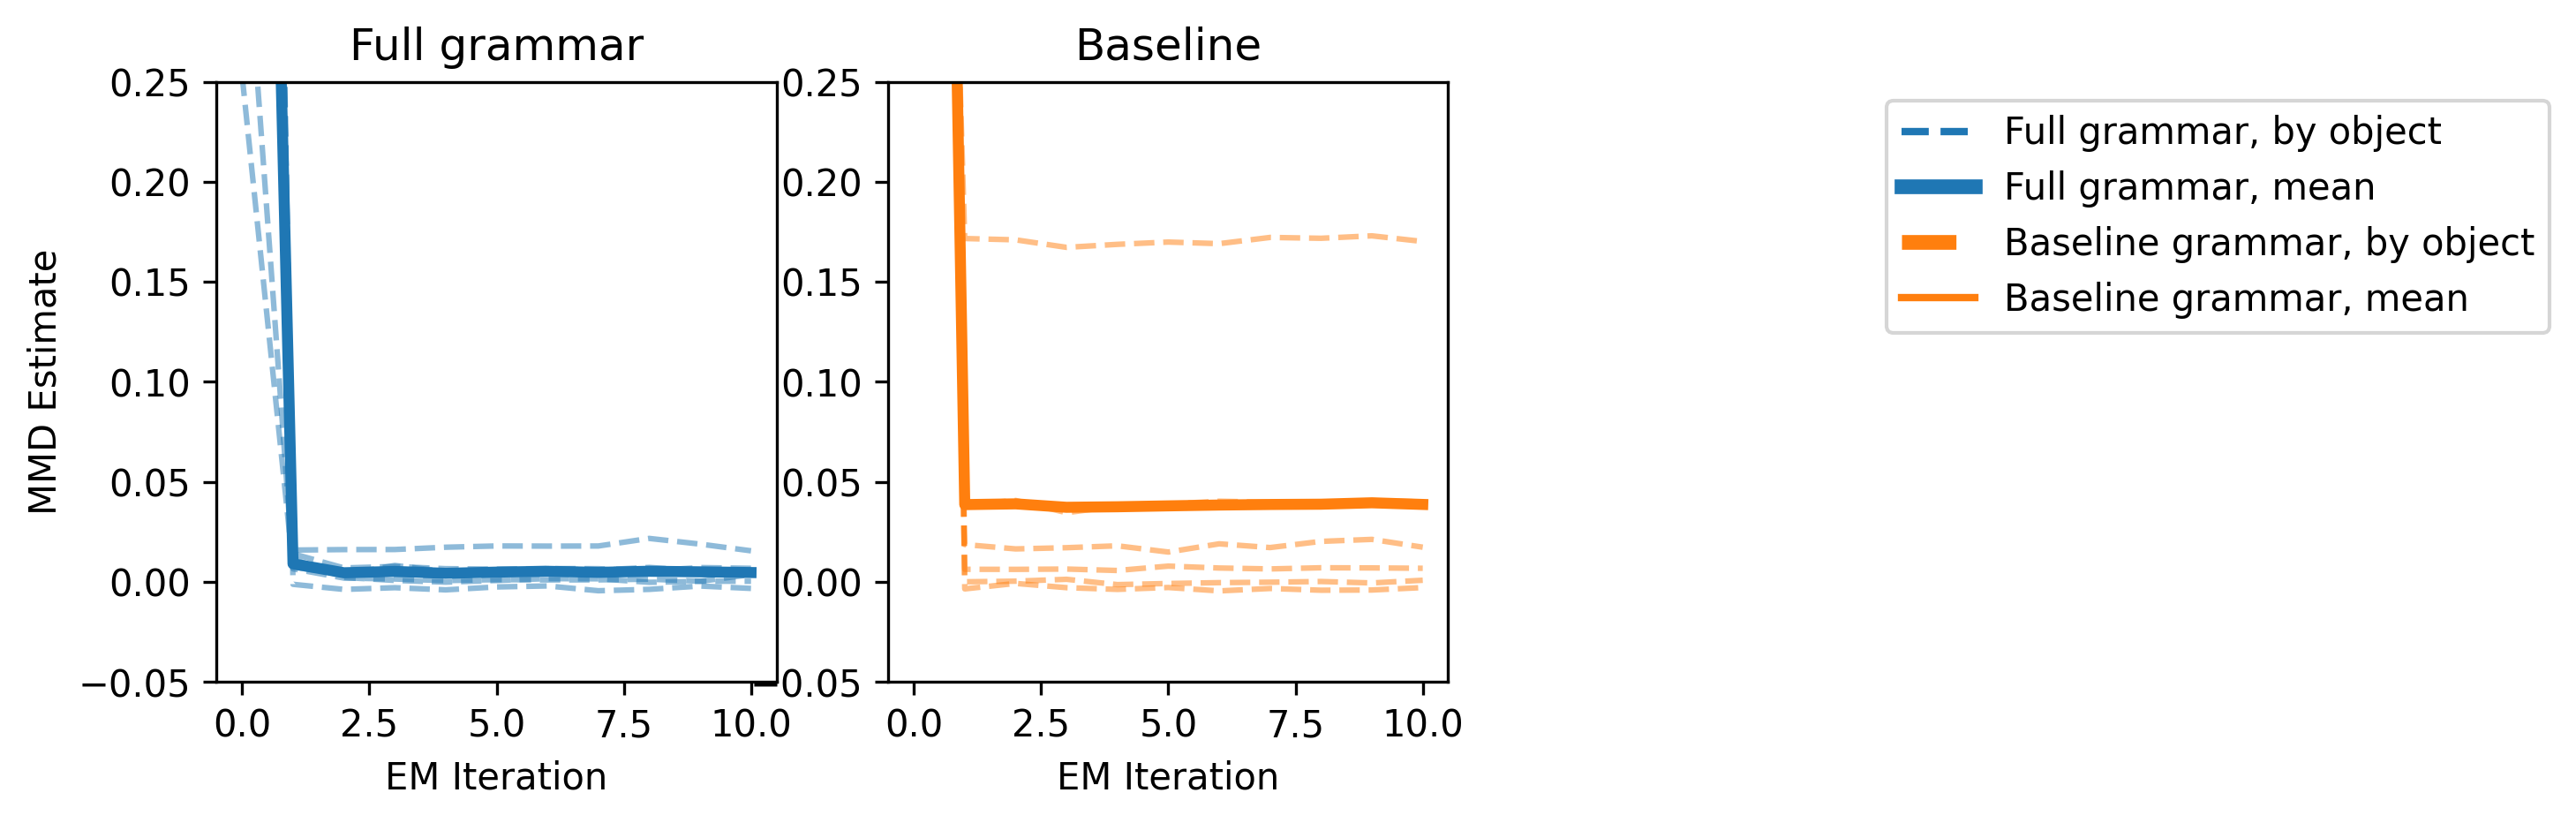

In [13]:
# Plot all of those over time.
plt.figure(dpi=300).set_size_inches(6, 3)

plt.subplot(1, 2, 1)
stacked_values = []
for key, value in mmds_by_type.items():
    if key == "Table":
        continue
    plt.plot(value, alpha=0.5, linestyle="--", c="tab:blue")
    stacked_values.append(torch.tensor(value))
stacked_values = torch.stack(stacked_values)
xs = range(stacked_values.shape[1])
means = torch.mean(stacked_values, dim=0)
stds = torch.std(stacked_values, dim=0)
maxes = stacked_values.max(dim=0).values
mins = stacked_values.min(dim=0).values
plt.plot(xs, means, linewidth=3, color="tab:blue")
#plt.fill_between(xs, mins, maxes, alpha=0.25, color="tab:blue")
plt.ylabel("MMD Estimate")
plt.xlabel("EM Iteration")
plt.title("Full grammar")
plt.ylim([-0.05, 0.25])

plt.subplot(1, 2, 2)
stacked_values_baseline = []
for key, value in mmds_by_type_baseline.items():
    if key == "TableBaseline":
        continue
    plt.plot(value, alpha=0.5, linestyle="--", c="tab:orange")
    stacked_values_baseline.append(torch.tensor(value))
stacked_values_baseline = torch.stack(stacked_values_baseline)
xs = range(stacked_values_baseline.shape[1])
means = torch.mean(stacked_values_baseline, dim=0)
stds = torch.std(stacked_values_baseline, dim=0)
maxes = stacked_values_baseline.max(dim=0).values
mins = stacked_values_baseline.min(dim=0).values
plt.plot(xs, means, linewidth=3, color="tab:orange")
#plt.fill_between(xs, mins, maxes, alpha=0.25, color="tab:orange")
plt.title("Baseline")
plt.ylim([-0.05, 0.25])

plt.xlabel("EM Iteration")
# Custom legend
from matplotlib.lines import Line2D
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_lines = [Line2D([0], [0], ls="dashed", color="tab:blue", lw=2, label="Full grammar, by object"),
                Line2D([0], [0], color="tab:blue", lw=4, label="Full grammar, mean"),
                Line2D([0], [0], ls="dashed", color="tab:orange", lw=4, label="Baseline grammar, by object"),
                Line2D([0], [0], color="tab:orange", lw=2, label="Baseline grammar, mean")]
plt.gca().legend(handles=custom_lines, bbox_to_anchor=[1.75, 1])
initial_mmds = stacked_values[:, 0]
last_mmds = stacked_values[:, -1]
print("Initial: %f +/- %f" % (torch.mean(initial_mmds), torch.std(initial_mmds)))
print("Final: %f +/- %f" % (torch.mean(last_mmds), torch.std(last_mmds)))


print("FULL:")
for key, value in mmds_by_type.items():
    print("%s: full %s" % (key, value[-1]))
    
print("BASELINE:")
for key, value in mmds_by_type_baseline.items():
    print("%s: full %s" % (key, value[-1]))

Text(0.5, 1.0, 'Weights of child types of "PlaceSetting"\nduring EM process')

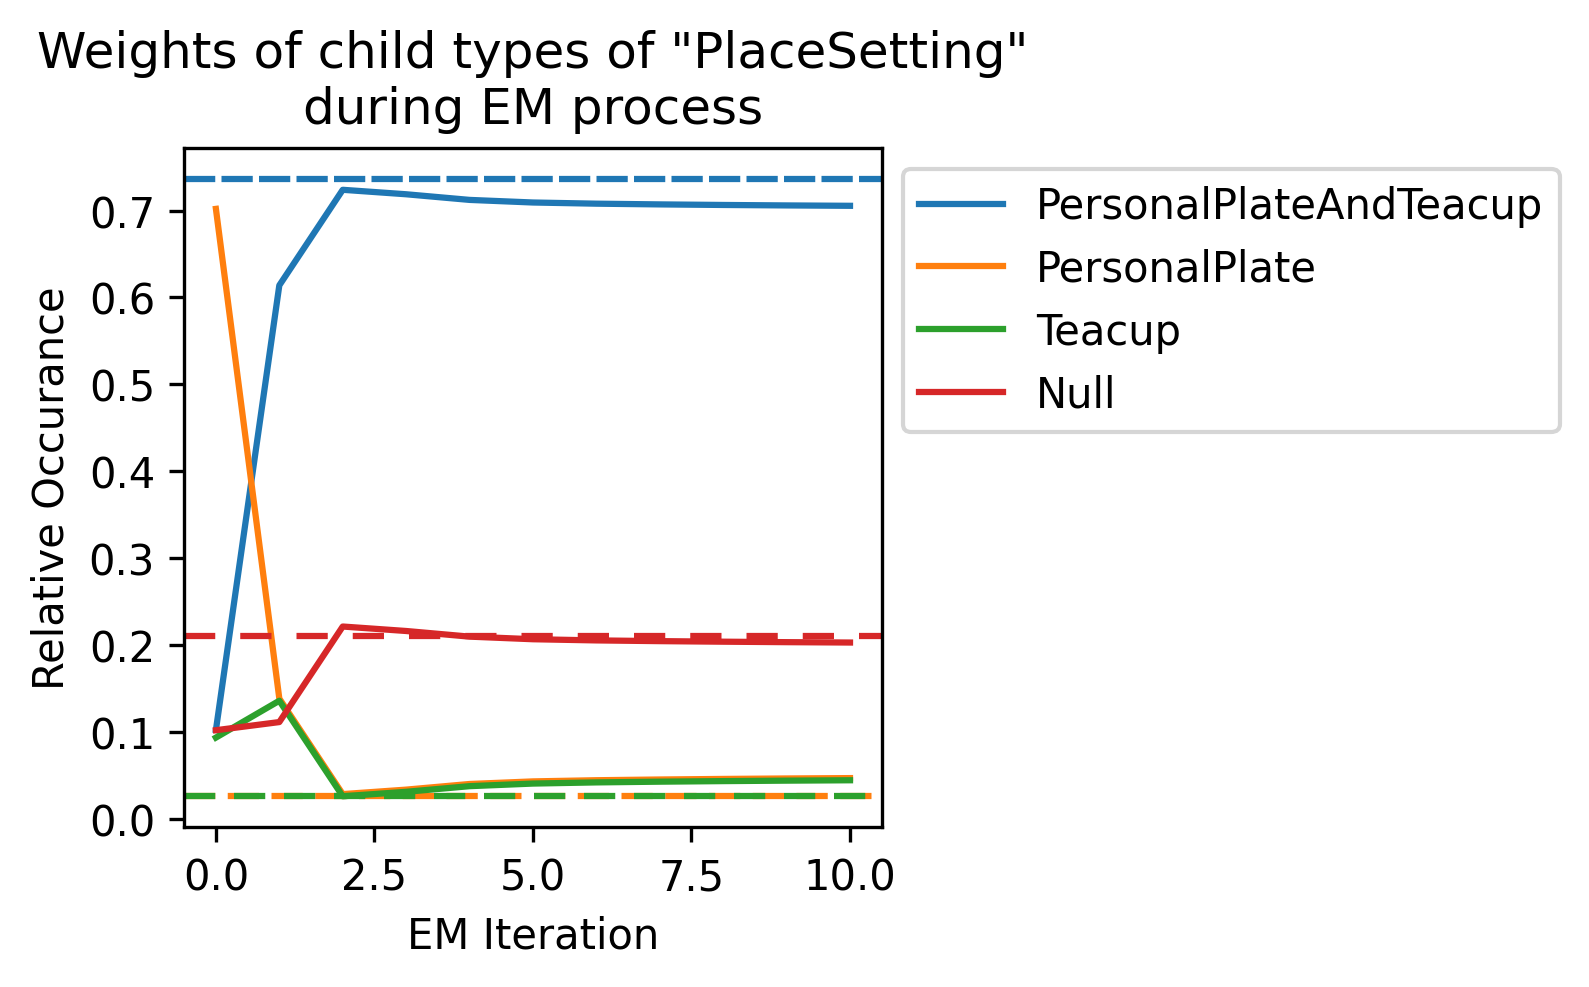

In [95]:
# Extract grammar history for PlaceSetting and label it appropriately
object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["PlaceSetting"]().detach().numpy())
object_params_history = np.stack(object_params_history)

gt_params = gt_grammar.params_by_node_type["PlaceSetting"]().detach().numpy()
rule_counts = np.zeros(object_params_history.shape[1])
total = 0
for tree in target_dataset_trees:
    parents = tree.find_nodes_by_type(PlaceSetting)
    for parent in parents:
        for child in tree.successors(parent):
            rule_counts[child.rule_k] += 1
            total += 1
measured_params = rule_counts / total

object_child_types = [rule.child_type.__name__ for rule in PlaceSetting.generate_rules()]
plt.figure(dpi=300).set_size_inches(3, 3)
for k, child_name in enumerate(object_child_types):
    stuff = plt.plot(object_params_history[:, k], label=child_name)
    plt.axhline(gt_params[k], linestyle="--", c=stuff[0].get_c(), dashes=(5, k+1))
    #plt.axhline(measured_params[k], linestyle="--", c=stuff[0].get_c(), dashes=(1, k+1))

plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("EM Iteration")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"PlaceSetting\"\nduring EM process")

<class 'spatial_scene_grammars_examples.table.grammar.PersonalPlate'> [[ 0.04470613 -0.00143811 -0.03475245]
 [ 0.04459096  0.02318333 -0.03475245]
 [ 0.03257958  0.01049402 -0.03475245]
 [ 0.02967797 -0.04195933 -0.03474013]
 [ 0.03504338 -0.00209028 -0.03474013]
 [ 0.03654732  0.00747937 -0.03475245]
 [ 0.08203151 -0.05929992 -0.03475245]
 [ 0.02735116  0.00643053 -0.03474013]
 [ 0.08755446  0.01141176 -0.03475245]
 [ 0.02893289 -0.00584325 -0.03475245]
 [ 0.02866695 -0.04897479 -0.03474013]]
[0. 0. 0.]
<class 'spatial_scene_grammars_examples.table.grammar.Teacup'> [[ 0.20283826 -0.08131746 -0.0336146 ]
 [ 0.23147551  0.00857185 -0.03583857]
 [ 0.22632255  0.07539883 -0.03466045]
 [ 0.26679169  0.04555862 -0.03580545]
 [ 0.22745598 -0.1375951  -0.03586004]
 [ 0.25059244  0.125378   -0.03567237]
 [ 0.21669332 -0.0023622  -0.03585423]
 [ 0.25133705 -0.12464602 -0.03584022]
 [ 0.27990809  0.13177023 -0.03473849]
 [ 0.24744465  0.13455098 -0.03466936]]
[0.25 0.   0.  ]


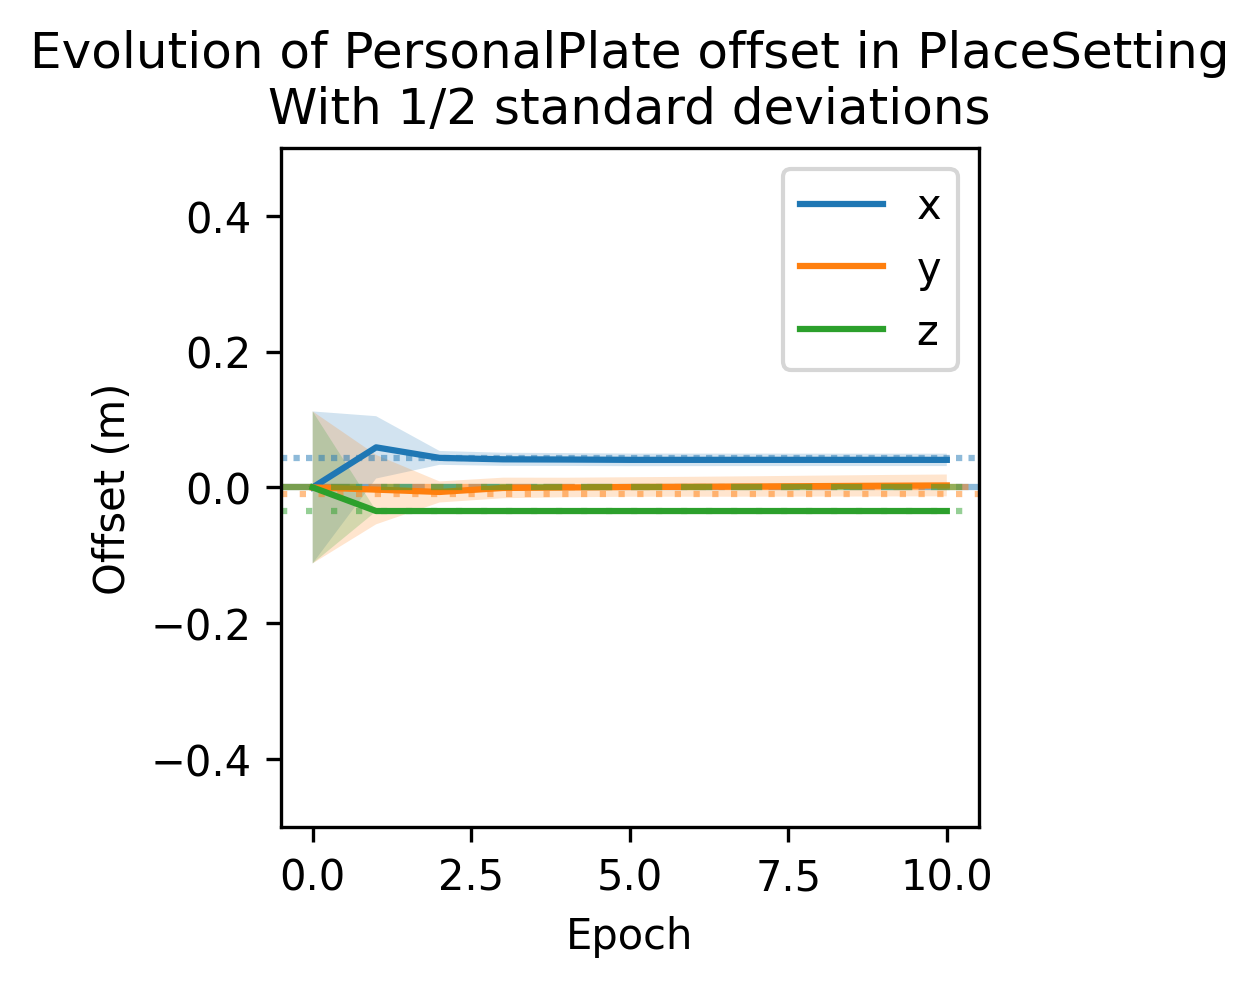

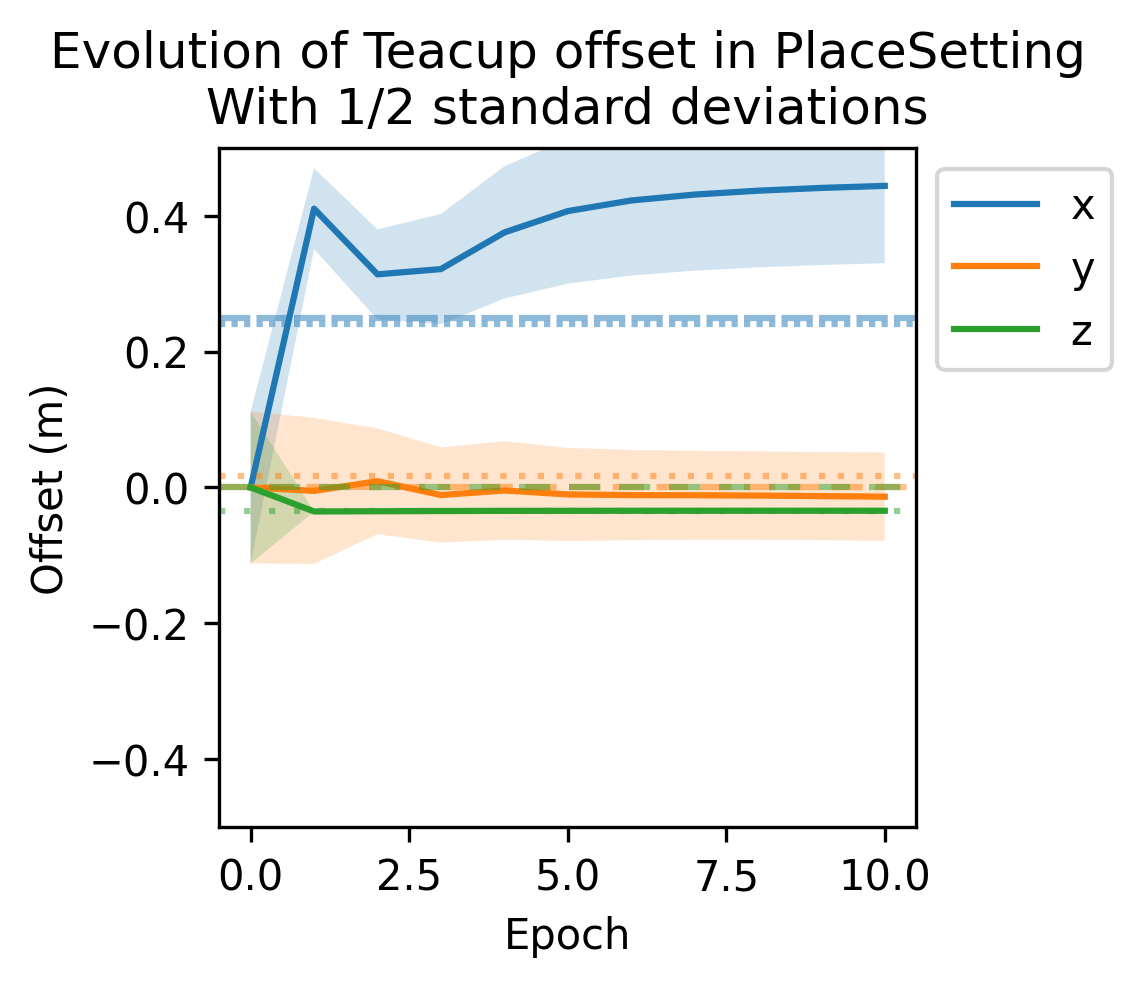

In [30]:
# Extract grammar history for PlaceSetting xyz offsets for each child
for rule_k, rule in enumerate(PlaceSetting.generate_rules()):
    if isinstance(rule.xyz_rule, SamePositionRule):
        continue

    t_mean_history = []
    t_var_history = []
    for grammar_state_dict in em.grammar_iters:
        grammar.load_state_dict(grammar_state_dict)
        t_mean_history.append(grammar.rule_params_by_node_type["PlaceSetting"][rule_k][0]["mean"]().detach().numpy().copy())
        t_var_history.append(grammar.rule_params_by_node_type["PlaceSetting"][rule_k][0]["variance"]().detach().numpy().copy())
    t_mean_history = np.stack(t_mean_history)
    t_var_history = np.stack(t_var_history)

    gt_t = gt_grammar.rule_params_by_node_type["PlaceSetting"][rule_k][0]["mean"]().detach().numpy()
    t_obs = []
    for tree in target_dataset_trees:
        for node in tree.find_nodes_by_type(rule.child_type):
            parent = tree.get_parent(node)
            if isinstance(parent, PlaceSetting) and node.rule_k == rule_k:
                t_obs.append(
                    torch.matmul(parent.rotation.T, node.translation - parent.translation).detach().numpy()
                )
    t_obs = np.stack(t_obs)
    print(rule.child_type, t_obs)
    observed_t = t_obs.mean(axis=0)
    

    plt.figure(dpi=300).set_size_inches(3, 3)
    t_std_history = np.sqrt(t_var_history)*0.5
    for k in range(3):
        xs = range(t_mean_history.shape[0])
        thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
        plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)
        plt.axhline(gt_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(5, 1+k))
        plt.axhline(observed_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(1, 1+k))

    plt.ylim(-0.5, 0.5)
    plt.xlabel("Epoch")
    plt.ylabel("Offset (m)")
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title("Evolution of %s offset in PlaceSetting\nWith 1/2 standard deviations" % rule.child_type.__name__)
    print(gt_t)

[0. 0. 0.]
[0.25 0.   0.  ]


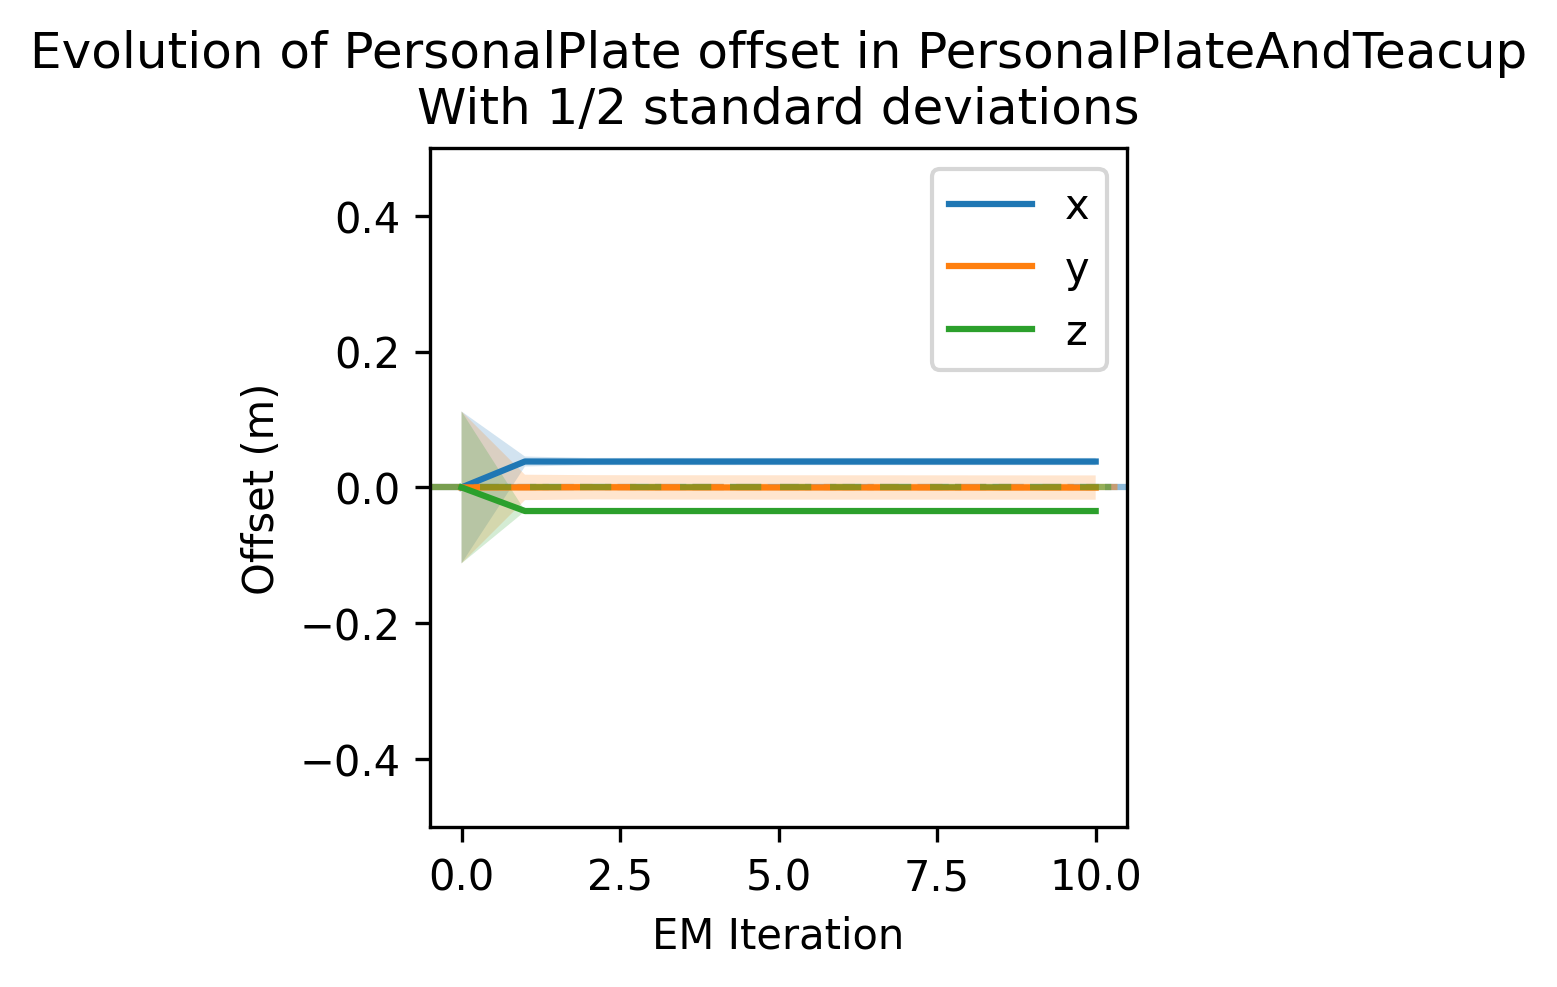

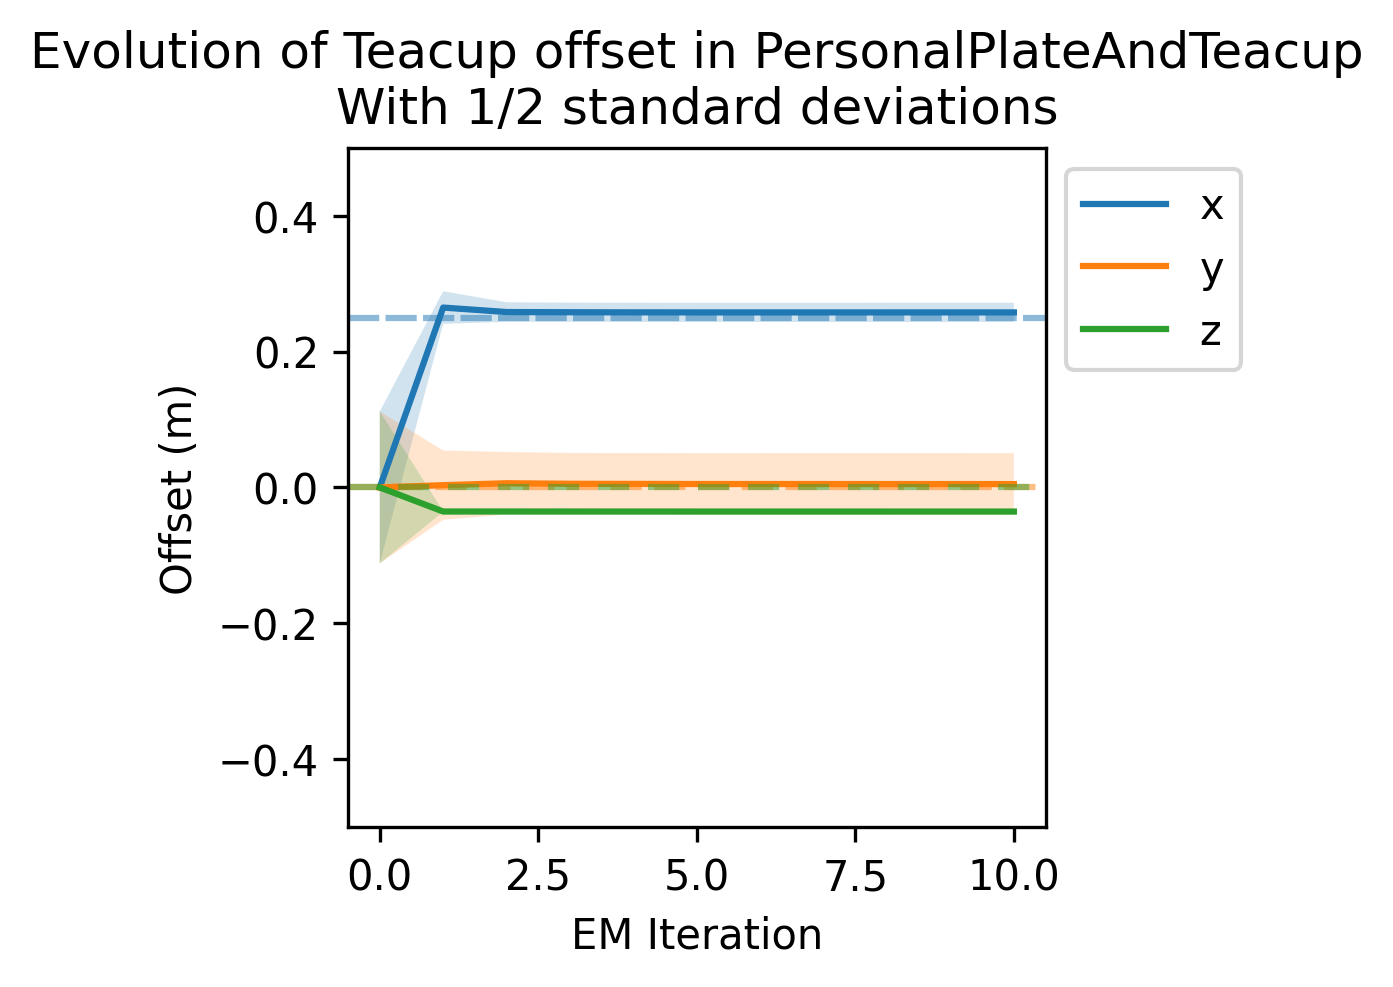

In [96]:
# Extract grammar history for PersonalPlateAndTeacup xyz offsets for each child
for rule_k, rule in enumerate(PersonalPlateAndTeacup.generate_rules()):
    t_mean_history = []
    t_var_history = []
    for grammar_state_dict in em.grammar_iters:
        grammar.load_state_dict(grammar_state_dict)
        t_mean_history.append(grammar.rule_params_by_node_type["PersonalPlateAndTeacup"][rule_k][0]["mean"]().detach().numpy().copy())
        t_var_history.append(grammar.rule_params_by_node_type["PersonalPlateAndTeacup"][rule_k][0]["variance"]().detach().numpy().copy())
    t_mean_history = np.stack(t_mean_history)
    t_var_history = np.stack(t_var_history)

    gt_t = gt_grammar.rule_params_by_node_type["PersonalPlateAndTeacup"][rule_k][0]["mean"]().detach().numpy()
    t_obs = []
    for tree in target_dataset_trees:
        for node in tree.find_nodes_by_type(rule.child_type):
            parent = tree.get_parent(node)
            if isinstance(parent, PersonalPlateAndTeacup) and node.rule_k == rule_k:
                t_obs.append(
                    torch.matmul(parent.rotation.T, node.translation - parent.translation).detach().numpy()
                )
    t_obs = np.stack(t_obs)
    observed_t = t_obs.mean(axis=0)
    

    plt.figure(dpi=300).set_size_inches(3, 3)
    t_std_history = np.sqrt(t_var_history)*0.5
    for k in range(3):
        xs = range(t_mean_history.shape[0])
        thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
        plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)
        plt.axhline(gt_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(5, 1+k))
        #plt.axhline(observed_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(1, 1+k))

    plt.ylim(-0.5, 0.5)
    plt.xlabel("EM Iteration")
    plt.ylabel("Offset (m)")
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title("Evolution of %s offset in PersonalPlateAndTeacup\nWith 1/2 standard deviations" % rule.child_type.__name__)
    print(gt_t)

[0.  0.  0.1]
[0.  0.  0.1]


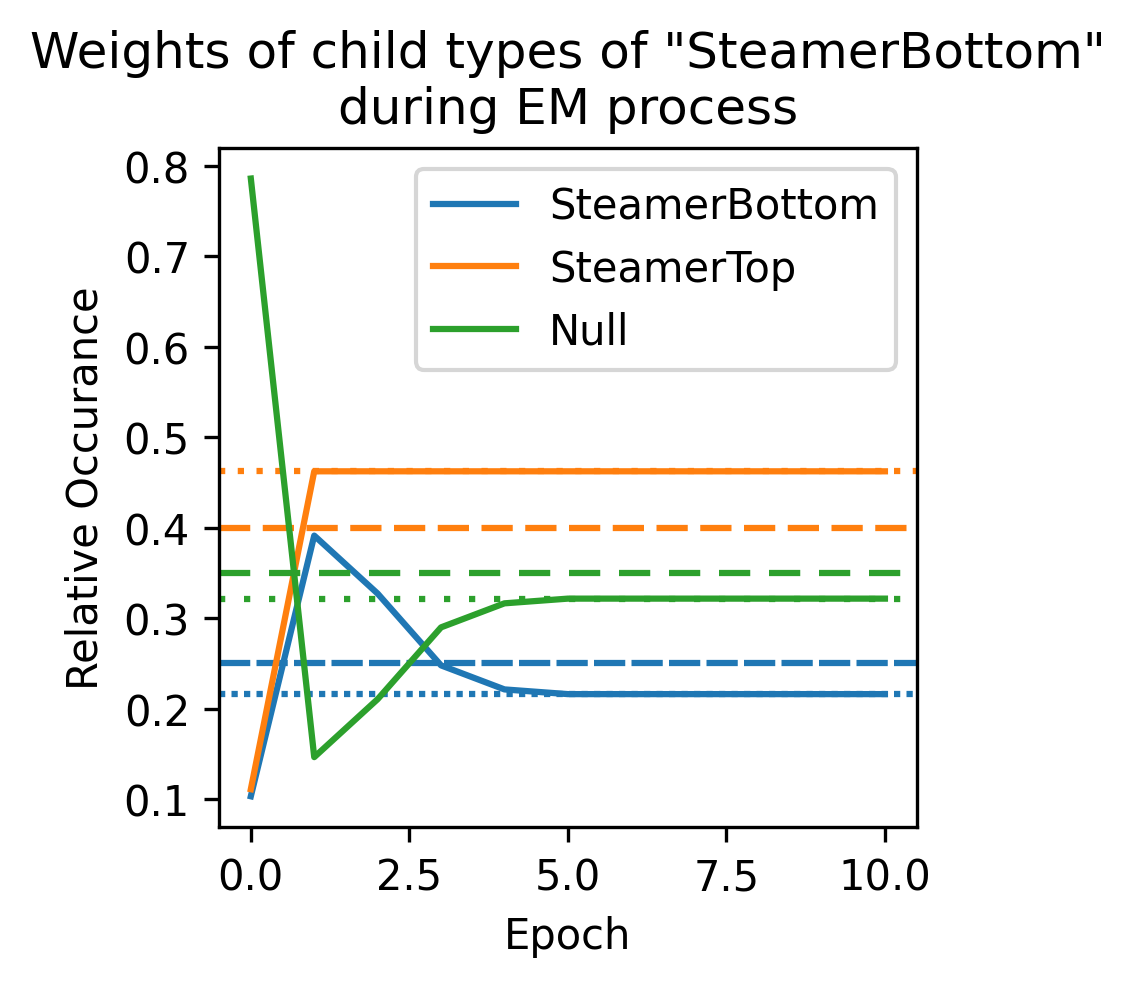

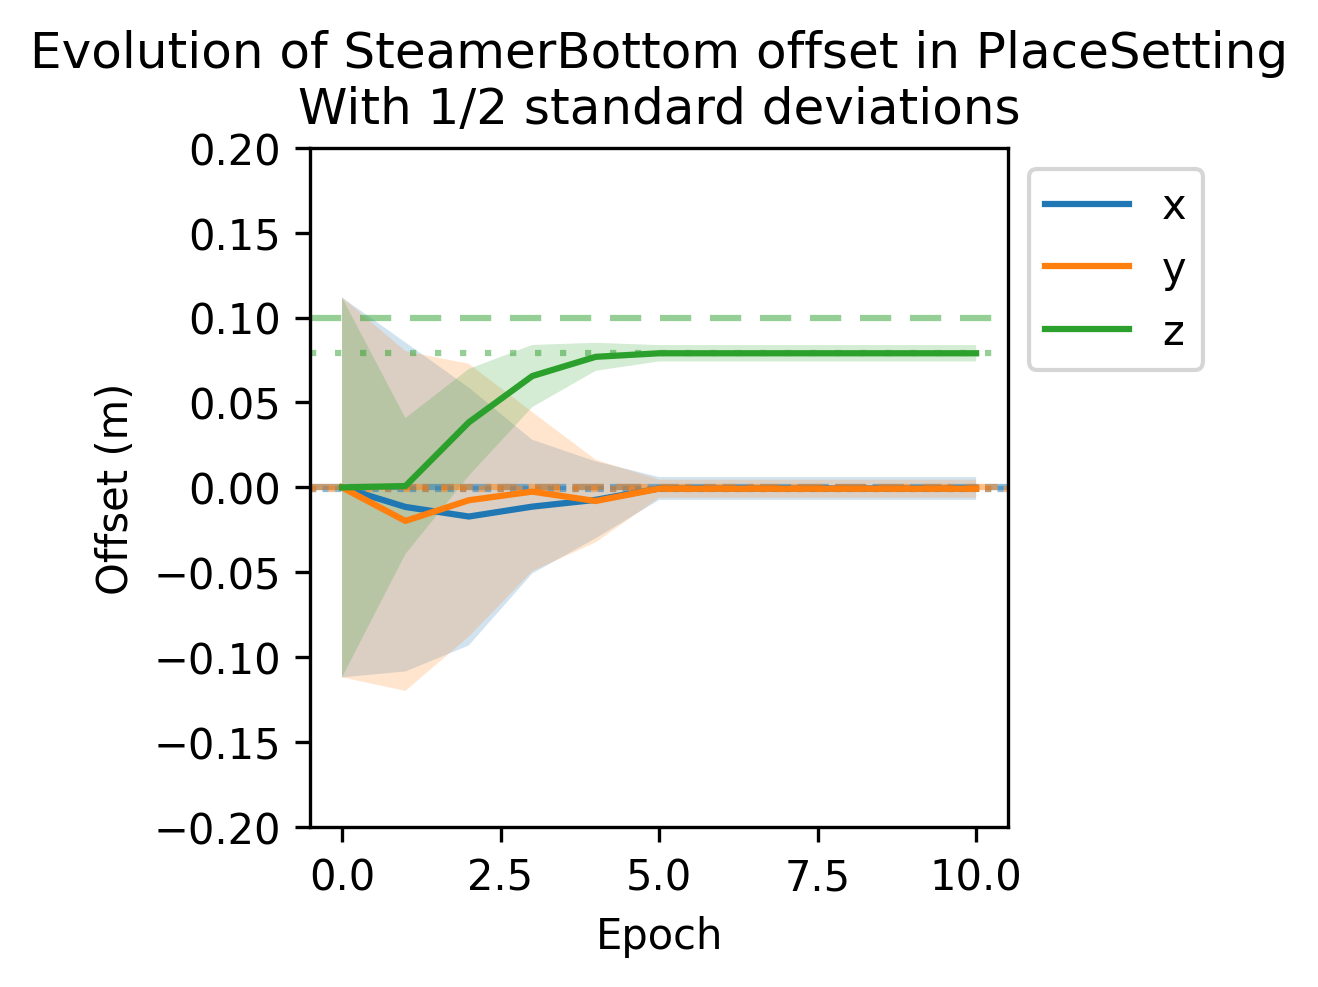

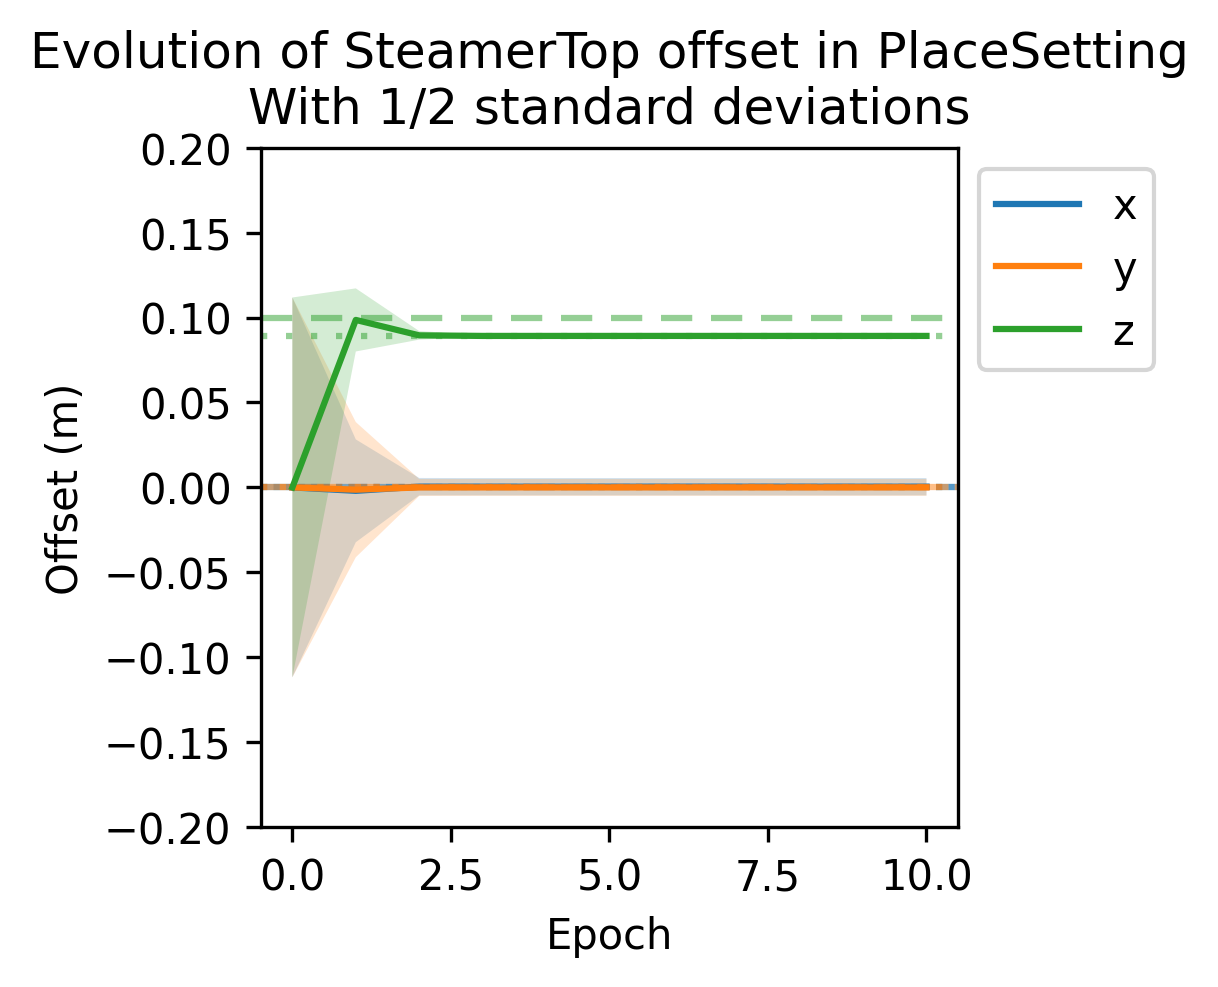

In [33]:
# Extract grammar history for SteamerBottom params + xyz offsets for first two (non-null) children

object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["SteamerBottom"]().detach().numpy())
gt_params = gt_grammar.params_by_node_type["SteamerBottom"]().detach().numpy()
object_params_history = np.stack(object_params_history)

rule_counts = np.zeros(object_params_history.shape[1])
total = 0
for tree in target_dataset_trees:
    parents = tree.find_nodes_by_type(SteamerBottom)
    for parent in parents:
        for child in tree.successors(parent):
            rule_counts[child.rule_k] += 1
            total += 1
observed_params = rule_counts / total


object_child_types = [rule.child_type.__name__ for rule in SteamerBottom.generate_rules()]
plt.figure(dpi=300).set_size_inches(3, 3)
for k, child_name in enumerate(object_child_types):
    stuff = plt.plot(object_params_history[:, k], label=child_name)
    plt.axhline(gt_params[k], linestyle="--", c=stuff[0].get_c(), dashes=(5, 1+k))
    plt.axhline(observed_params[k], linestyle="--", c=stuff[0].get_c(), dashes=(1, 1+k))
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"SteamerBottom\"\nduring EM process")

for rule_k, rule in enumerate(SteamerBottom.generate_rules()[:2]):
    t_mean_history = []
    t_var_history = []
    for grammar_state_dict in em.grammar_iters:
        grammar.load_state_dict(grammar_state_dict)
        t_mean_history.append(grammar.rule_params_by_node_type["SteamerBottom"][rule_k][0]["mean"]().detach().numpy().copy())
        t_var_history.append(grammar.rule_params_by_node_type["SteamerBottom"][rule_k][0]["variance"]().detach().numpy().copy())
    t_mean_history = np.stack(t_mean_history)
    t_var_history = np.stack(t_var_history)

    gt_t = gt_grammar.rule_params_by_node_type["SteamerBottom"][rule_k][0]["mean"]().detach().numpy()
    t_obs = []
    for tree in target_dataset_trees:
        for node in tree.find_nodes_by_type(rule.child_type):
            parent = tree.get_parent(node)
            if isinstance(parent, SteamerBottom) and node.rule_k == rule_k:
                t_obs.append(
                    torch.matmul(parent.rotation.T, node.translation - parent.translation).detach().numpy()
                )
    t_obs = np.stack(t_obs)
    observed_t = t_obs.mean(axis=0)
    
    plt.figure(dpi=300).set_size_inches(3, 3)
    t_std_history = np.sqrt(t_var_history)*0.5
    for k in range(3):
        xs = range(t_mean_history.shape[0])
        thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
        plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)
        plt.axhline(gt_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(5, 1+k))
        plt.axhline(observed_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(1, 1+k))
    
    plt.ylim(-0.2, 0.2)
    plt.xlabel("Epoch")
    plt.ylabel("Offset (m)")
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title("Evolution of %s offset in PlaceSetting\nWith 1/2 standard deviations" % rule.child_type.__name__)
    print(gt_t)

# Plot spatial distribution of samples
Assumes samples were generated and saved to file by generate_target_dataset

In [9]:
#with open("target_dataset_examples.pickle", "rb") as f:
#with open("structure_constraint_examples.pickle", "rb") as f:
#with open("pre_fit_grammar_draws.pickle", "rb") as f:
#with open("post_fit_grammar_draws.pickle", "rb") as f:
#with open("baseline_post_fit_grammar_draws.pickle", "rb") as f:
post_fit_trees = []
with open("post_fit_grammar_draws.pickle", "rb") as f:
    while 1:
        try:
            post_fit_trees.append(pickle.load(f)[1])
        except EOFError:
            break
print("Loaded %d environments" % len(post_fit_trees))


baseline_trees = []
with open("baseline_post_fit_grammar_draws.pickle", "rb") as f:
    while 1:
        try:
            baseline_trees.append(pickle.load(f)[1])
        except EOFError:
            break
print("Loaded %d environments" % len(baseline_trees))

gt_trees = []
with open("target_dataset_examples.pickle", "rb") as f:
    while 1:
        try:
            gt_trees.append(pickle.load(f))
        except EOFError:
            break
print("Loaded %d environments" % len(baseline_trees))

Loaded 50 environments
Loaded 30 environments
Loaded 30 environments


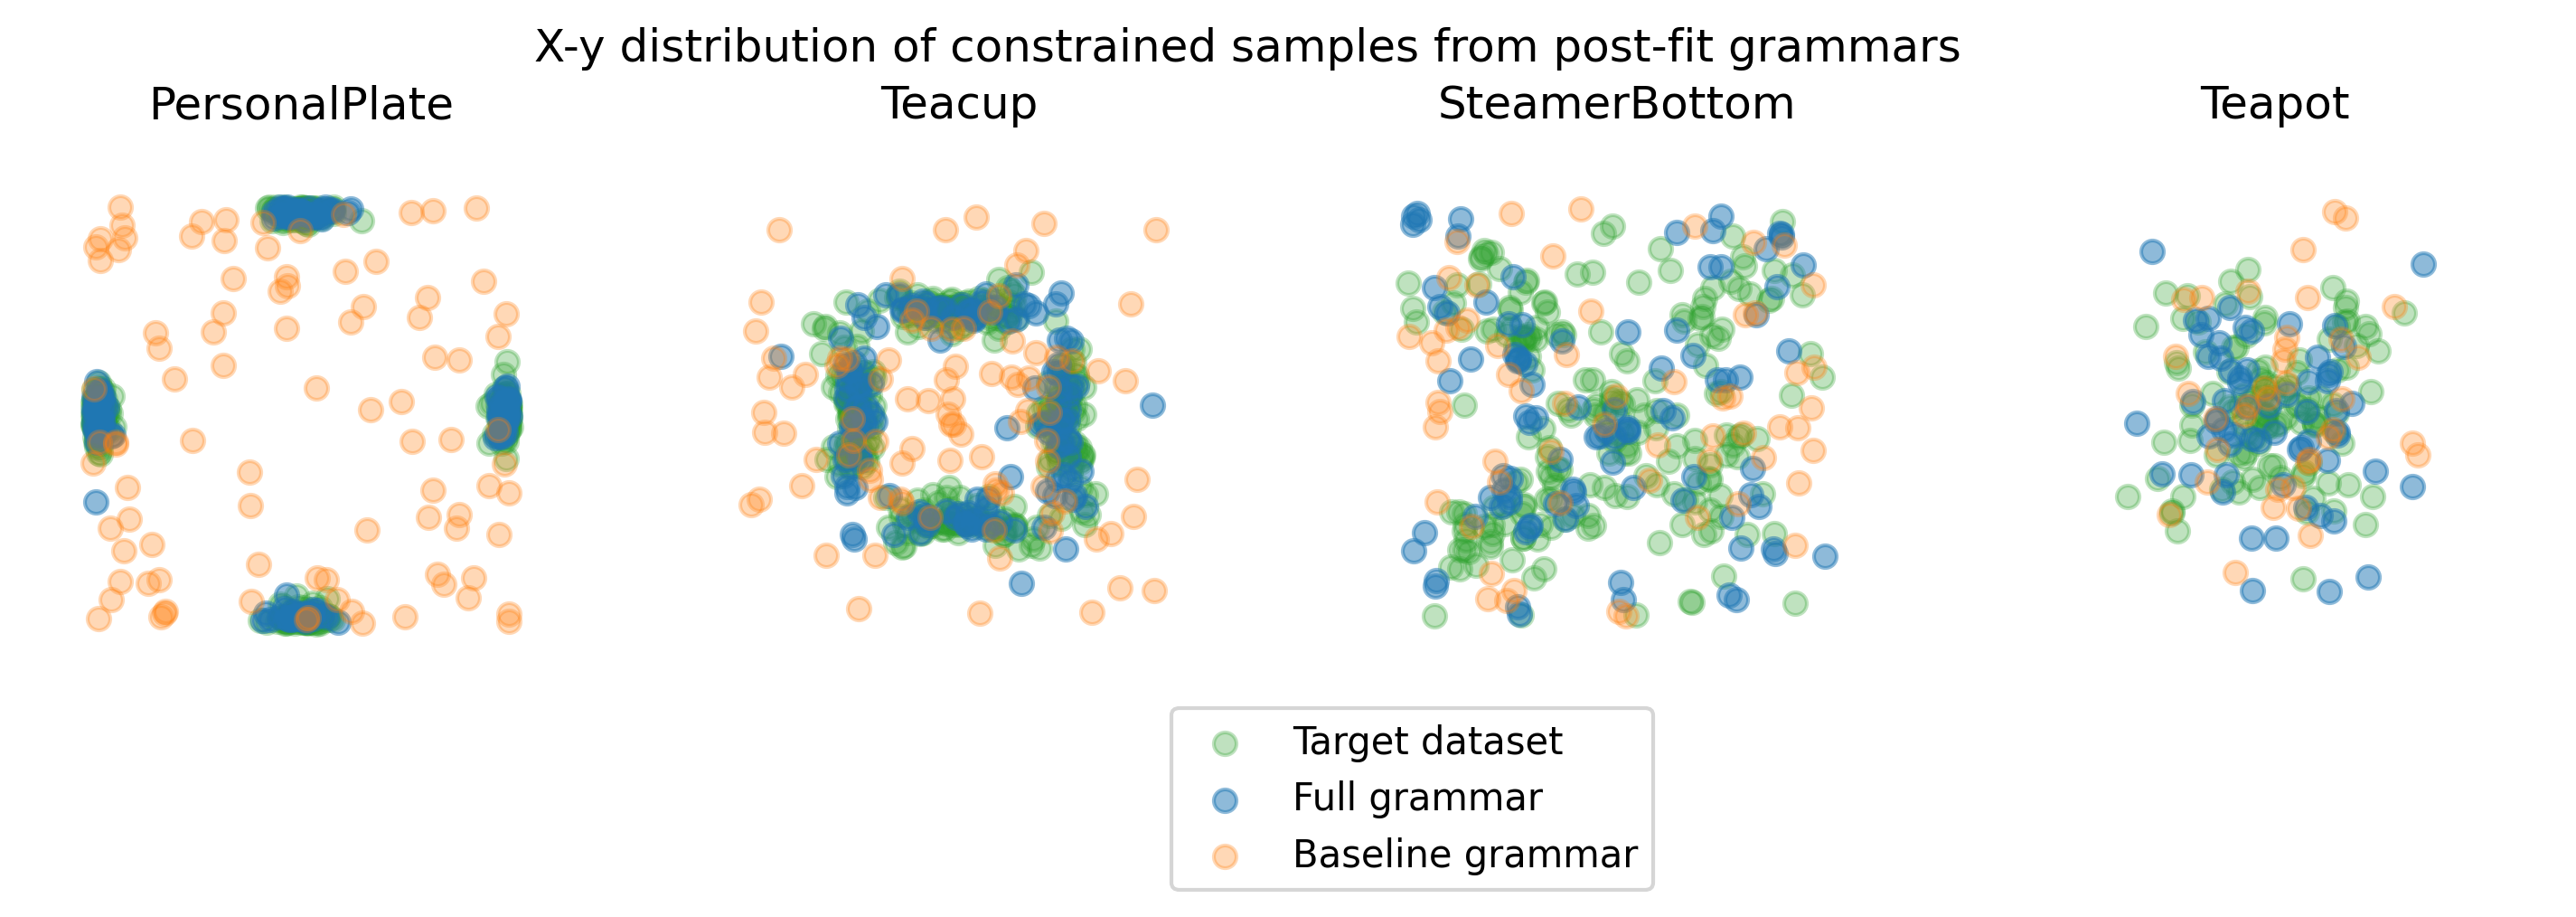

In [46]:
from matplotlib import patches

def get_xyz_stats_for_type(trees, target_type):
    xyzs = []
    for tree in trees:
        nodes = tree.find_nodes_by_type(target_type)
        xyzs += [n.translation.detach().numpy() for n in nodes]
    return np.stack(xyzs)

plt.figure(dpi=300).set_size_inches(4*3, 1*3)
plt.suptitle("X-y distribution of constrained samples from post-fit grammars")
target_types =  [PersonalPlate, Teacup, SteamerBottom, Teapot]
for k, target_type in enumerate(target_types):
    plt.subplot(1, len(target_types), k+1)
    plt.title(target_type.__name__)
    
    xyzs_gt = get_xyz_stats_for_type(gt_trees, target_type)
    xyzs_full = get_xyz_stats_for_type(post_fit_trees, target_type)
    if target_type is SteamerBottom:
        target_type = SteamerBottomBaseline
    xyzs_baseline = get_xyz_stats_for_type(baseline_trees, target_type)
    
    
    plt.scatter(xyzs_gt[:, 0], xyzs_gt[:, 1], label="Target dataset", c="tab:green", alpha=0.3)
    plt.scatter(xyzs_full[:, 0], xyzs_full[:, 1], label="Full grammar", c="tab:blue", alpha=0.5)
    plt.scatter(xyzs_baseline[:, 0], xyzs_baseline[:, 1], label="Baseline grammar", c="tab:orange", alpha=0.3)
    plt.xlim([-Table.WIDTH/2., Table.WIDTH/2.])
    plt.ylim([-Table.WIDTH/2., Table.WIDTH/2.])
    #heatmap, xedges, yedges = np.histogram2d(plate_xys[:, 0], plate_xys[:, 1], bins=50)
    #plt.imshow(heatmap, cmap="viridis")
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')
    
    if k == 0:
        plt.legend(bbox_to_anchor=[len(target_types)*.75, 0.])
    